Notebook to conceptualize a way to find cells in immunos/dye tracings, and analyze location/density/etc. 

In [155]:
import tifffile
import numpy as np
import matplotlib.pyplot as plt
from cellpose import models, io, core
from cellpose.io import imread
from scipy.ndimage import median_filter

use_GPU = core.use_gpu()
print('>>> GPU activated? %d'%use_GPU)
io.logger_setup()
model = models.Cellpose(gpu=use_GPU, model_type='cyto3')
#img3d = tifffile.imread(r"D:\Box Sync\confocal\retina\immunos\66\optimization\fixation test isl2_calret_brn3c\Composite.tif")
img3d = tifffile.imread(r"D:\Box Sync\confocal\retina\immunos\xenopus.tif")
img3d = img3d[190:195, 0:4,:,:]
# Example shape: (Z, C, Y, X)
img3d_filtered = np.empty_like(img3d)
for c in range(img3d.shape[1]):
    img3d_filtered[:, c] = median_filter(img3d[:, c], size=(1, 2, 2))

img3d = img3d_filtered


2025-05-08 13:57:54,073 [INFO] ** TORCH CUDA version installed and working. **
>>> GPU activated? 1
creating new log file
2025-05-08 13:57:54,074 [INFO] WRITING LOG OUTPUT TO C:\Users\Michael Forsthofer\.cellpose\run.log
2025-05-08 13:57:54,075 [INFO] 
cellpose version: 	3.1.1.1 
platform:       	win32 
python version: 	3.11.5 
torch version:  	2.6.0+cu118
2025-05-08 13:57:54,077 [INFO] ** TORCH CUDA version installed and working. **
2025-05-08 13:57:54,078 [INFO] >>>> using GPU (CUDA)
2025-05-08 13:57:54,078 [INFO] >> cyto3 << model set to be used
2025-05-08 13:57:54,153 [INFO] >>>> loading model C:\Users\Michael Forsthofer\.cellpose\models\cyto3
2025-05-08 13:57:54,248 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)


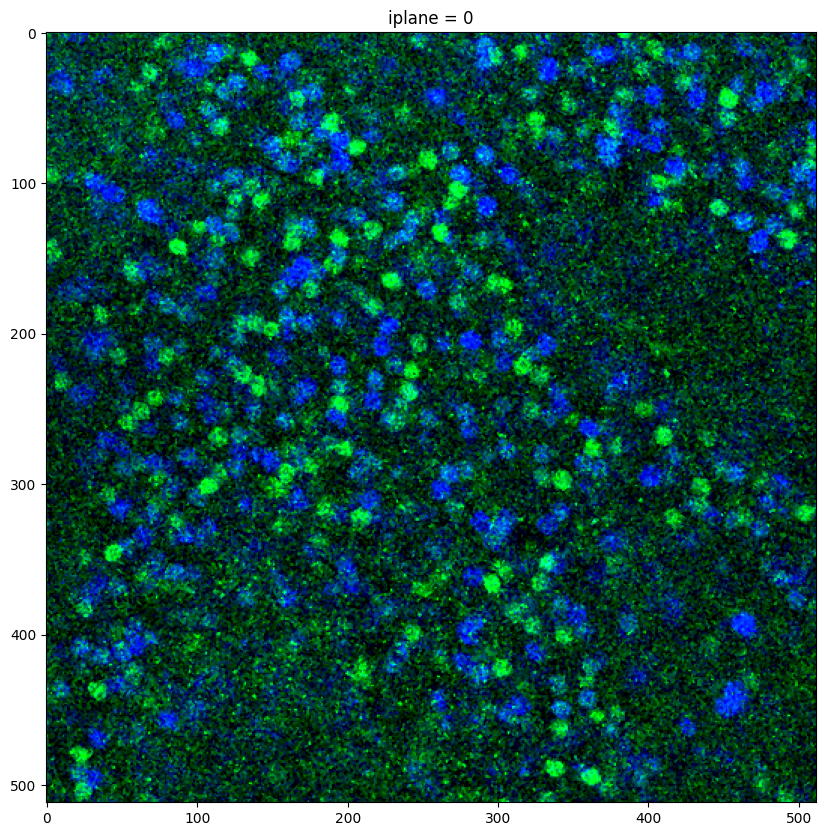

In [156]:
import numpy as np
from cellpose import plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
iplane = 0

# Create an RGB image
img0 = plot.image_to_rgb(img3d[iplane, [1,0]].copy(), channels=[3,2])

# Copy image for processing
imgout = img0.copy()

# Thresholding: Set pixels with any channel value < 5 to 0
threshold = 20
imgout[imgout < threshold] = 0

plt.imshow(imgout)
plt.title('iplane = %d' % iplane)
plt.show()




In [157]:
channels = [3, 2]
diameter = 20
min_size = 5
#create 3d flow, then make masks in that
#masks, flows, styles, _ = model.eval(img3d, channels=channels, diameter=diameter, do_3D=True, min_size=min_size, cellprob_threshold=0.8)
#create 2d masks, then combine them into 3d
masks, flows, styles, _ = model.eval(img3d, channels=channels, diameter=diameter, do_3D=False, min_size=min_size, stitch_threshold=0.5, anisotropy=5)

2025-05-08 13:57:59,381 [INFO] channels set to [3, 2]
2025-05-08 13:57:59,382 [INFO] ~~~ FINDING MASKS ~~~
2025-05-08 13:57:59,382 [INFO] multi-stack tiff read in as having 5 planes 4 channels
2025-05-08 13:58:00,790 [INFO] 100%|##########| 5/5 [00:01<00:00,  3.66it/s]
2025-05-08 13:58:00,811 [INFO] network run in 1.39s
2025-05-08 13:58:01,288 [INFO] 100%|##########| 5/5 [00:00<00:00, 10.50it/s]
2025-05-08 13:58:01,288 [INFO] stitching 5 planes using stitch_threshold=0.500 to make 3D masks


100%|██████████| 4/4 [00:00<00:00, 571.47it/s]

2025-05-08 13:58:01,322 [INFO] masks created in 0.51s
2025-05-08 13:58:01,394 [INFO] >>>> TOTAL TIME 2.01 sec


Text(0.5, 1.0, 'iplane = 0')

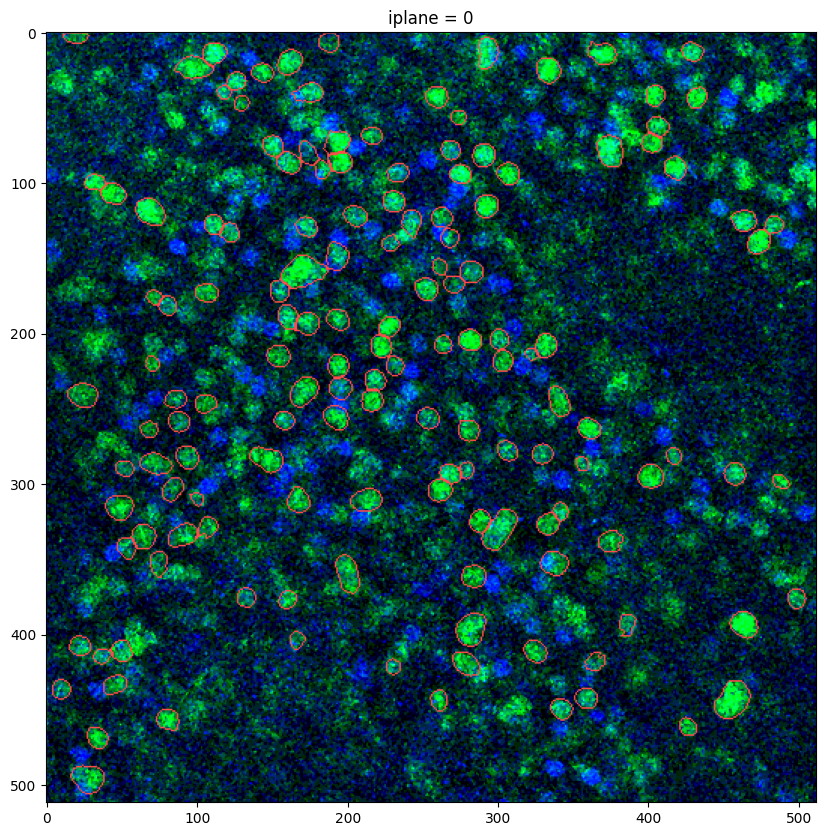

In [158]:
from cellpose import plot, utils
plt.figure(figsize=(10, 10))
iplane = 0
img0 = plot.image_to_rgb(img3d[iplane, [1,0]].copy(), channels=[2,3])

outlines = utils.masks_to_outlines(masks[iplane])
outX, outY = np.nonzero(outlines)
imgout= img0.copy()
imgout[outX, outY] = np.array([255,75,75])
plt.imshow(imgout)
plt.title('iplane = %d'%iplane)

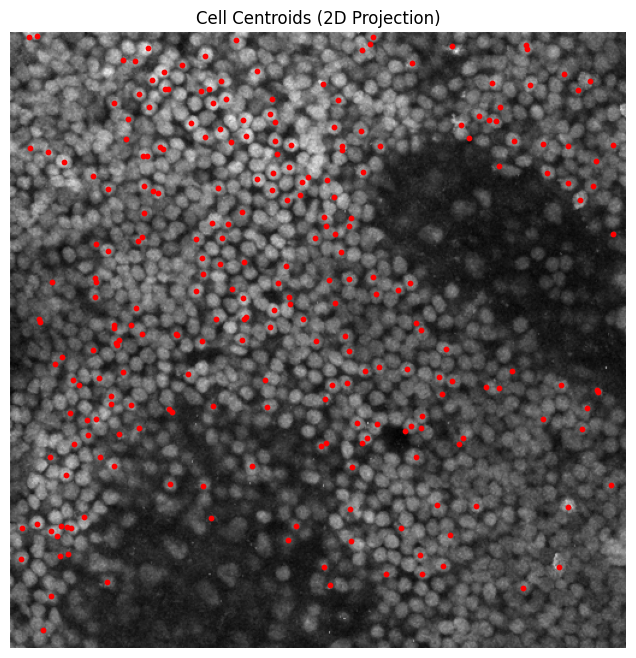

In [159]:
from scipy.ndimage import center_of_mass
import matplotlib.pyplot as plt

# Collapse the 3D mask into 2D by taking the max projection
masks_2d = masks.max(axis=0)  # shape: (Y, X)
# Get all unique object labels (skip 0, which is background)
labels = np.unique(masks_2d)
labels = labels[labels != 0]

# Compute centroids in 2D (Y, X)
centroids = center_of_mass(masks_2d, labels=masks_2d, index=labels)

# Convert to numpy array and split into X and Y
centroids = np.array(centroids)
y_coords, x_coords = centroids[:, 0], centroids[:, 1]

# Optional: show centroids on a max-projected image
img2d = img3d.max(axis=1).mean(axis=0)  # collapse Z and channel

plt.figure(figsize=(8, 8))
plt.imshow(img2d, cmap='gray')
plt.scatter(x_coords, y_coords, s=10, c='r')
plt.title('Cell Centroids (2D Projection)')
plt.axis('off')
plt.show()

ValueError: 'mako' is not a valid value for cmap; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Grays', 'Grays_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'berlin', 'berlin_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_grey', 'gist_grey_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gist_yerg', 'gist_yerg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'grey', 'grey_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'managua', 'managua_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'vanimo', 'vanimo_r', 'viridis', 'viridis_r', 'winter', 'winter_r'

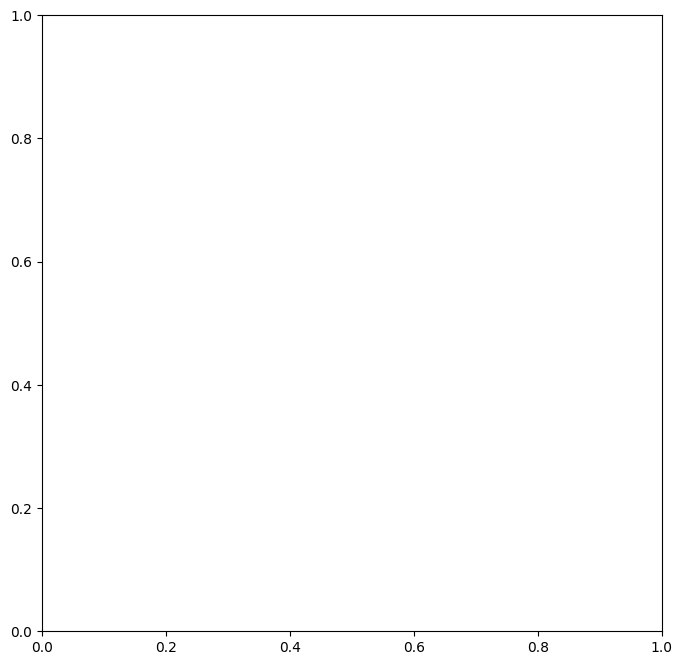

In [152]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Set up a grid the same size as your image
img_shape = img3d.shape[2:]  # (Y, X)
grid_x, grid_y = np.meshgrid(np.linspace(0, img_shape[1], img_shape[1]),
                             np.linspace(0, img_shape[0], img_shape[0]))

# Stack x and y coordinates
positions = np.vstack([grid_x.ravel(), grid_y.ravel()])
values = np.vstack([x_coords, y_coords])

# KDE with low bandwidth (sharper)
kde = gaussian_kde(values, bw_method=0.2)  # lower = sharper

# Evaluate KDE on grid
density = kde(positions).reshape(img_shape)

# Plot it
plt.figure(figsize=(8, 8))
plt.imshow(density, cmap='mako', origin='upper')
plt.colorbar(label='Density')
plt.title('Cell Density (Sharper KDE)')
plt.axis('equal')
plt.axis('off')
plt.show()

